In [ ]:
#| default_exp embeddings

# Embeddings

> Working with semantic embeddings of Earth

In [ ]:
#| hide
#| export
from nbdev.showdoc import *
import geopandas as gpd
from datetime import datetime
import numpy as np
from tqdm import tqdm
import pandas as pd
from pathlib import Path
import contextily as ctx
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image
import rasterio
import matplotlib.pyplot as plt


### What are Embeddings?

Embeddings in the context of Earth Observation (EO) and machine learning are dense, low-dimensional representations of high-dimensional data. In simple terms, they are numerical vectors that capture the essence of complex data, such as satellite imagery or temporal sequences from Earth observation instruments. These vectors are generated by models like Clay through a process of learning, where the model identifies and encodes the most important features and patterns within the data.

### Importance in EO
- **Data Compression**: Embeddings condense the rich information present in satellite images into a more manageable form, facilitating easier storage and faster processing.
- **Pattern Recognition**: They enable the model to recognize and compare patterns across large datasets, which is crucial for tasks like change detection, anomaly identification, or land cover classification.
- **Semantic Interpretation**: Embeddings help in understanding the semantic content of EO data, such as differentiating between urban and forested areas, or recognizing the stages of crop growth.

### How to Use Embeddings for EO

1. **Feature Extraction**: Use Clay to process EO data and extract embeddings. These embeddings represent the key features of the data, capturing aspects like spectral signatures, texture, and temporal changes.

2. **Similarity Searches**: Employ embeddings to perform similarity searches across EO datasets. For example, by comparing embeddings, you can find areas with similar land use patterns or detect regions showing similar changes over time.

3. **Machine Learning Integration**: Embeddings can be used as input features for various machine learning models. In tasks like classification or regression, these embeddings provide a rich, pre-processed input that can significantly improve model performance.

4. **Time-Series Analysis**: For temporal EO data, embeddings can capture the dynamics of changes over time, aiding in monitoring environmental changes, urban development, or agricultural practices.

5. **Anomaly Detection**: Compare embeddings from different time periods or regions to identify anomalies or unexpected changes in the environment, such as sudden forest loss or unusual agricultural activity.

In practice, to use embeddings in EO, you would typically process your EO dataset through the Clay model to generate embeddings, and then utilize these embeddings as per your specific application needs, be it for further analysis, integration into other models, or for direct comparisons and searches.

## Generating Embeddings


Once you have a pretrained model, it is now possible to pass some input images
into the encoder part of the Vision Transformer, and produce vector embeddings
which contain a semantic representation of the image.

### Producing embeddings from the pretrained model

Step by step instructions to create embeddings for a single MGRS tile location
(e.g. 27WXN).

1. Ensure that you can access the 13-band GeoTIFF data files.

   ```
   aws s3 ls s3://clay-tiles-02/02/27WXN/
   ```

   This should report a list of filepaths if you have the correct permissions,
   otherwise, please set up authentication before continuing.

2. Download the pretrained model weights, and put them in the `checkpoints/`
   folder.

   ```bash
   aws s3 cp s3://clay-model-ckpt/v0/clay-small-70MT-1100T-10E.ckpt checkpoints/
   ```

   ```{tip}
   For running model inference on a large scale (hundreds or thousands of MGRS
   tiles), it is recommended to have a cloud VM instance with:

   1. A high bandwidth network (>25Gbps) to speed up data transfer from the S3
      bucket to the compute device.
   2. An NVIDIA Ampere generation GPU (e.g. A10G) or newer, which would allow
      for efficient bfloat16 dtype calculations.

   For example, an AWS g5.4xlarge instance would be a cost effective option.
   ```

3. Run model inference to generate the embeddings.

   ```bash
   python trainer.py predict --ckpt_path=checkpoints/clay-small-70MT-1100T-10E.ckpt \
                             --trainer.precision=bf16-mixed \
                             --data.data_dir=s3://clay-tiles-02/02/27WXN \
                             --data.batch_size=32 \
                             --data.num_workers=16
   ```

   This should output a GeoParquet file containing the embeddings for MGRS tile
   27WXN (recall that each 10000x10000 pixel MGRS tile contains hundreds of
   smaller 512x512 chips), saved to the `data/embeddings/` folder. See the next
   sub-section for details about the embeddings file.

   ```{note}
   For those interested in how the embeddings were computed, the predict step
   above does the following:

   1. Pass the 13-band GeoTIFF input into the Vision Transformer's encoder, to
      produce raw embeddings of shape (B, 1538, 768), where B is the batch_size,
      1538 is the patch dimension and 768 is the embedding length. The patch
      dimension itself is a concatenation of 1536 (6 band groups x 16x16
      spatial patches of size 32x32 pixels each in a 512x512 image) + 2 (latlon
      embedding and time embedding) = 1538.
   2. The mean or average is taken across the 1536 patch dimension, yielding an
      output embedding of shape (B, 768).

   More details of how this is implemented can be found by inspecting the
   `predict_step` method in the `model_clay.py` file.
   ```


### Format of the embeddings file

The vector embeddings are stored in a single column within a
[GeoParquet](https://geoparquet.org) file (*.gpq), with other columns
containing spatiotemporal metadata. This file format is built on top of the
popular Apache Parquet columnar storage format designed for fast analytics,
and it is highly interoperable across different tools like QGIS,
GeoPandas (Python), sfarrow (R), and more.

#### Filename convention

The embeddings file utilizes the following naming convention:

```
{MGRS:5}_{MINDATE:8}_{MAXDATE:8}_v{VERSION:3}.gpq
```

Example: `27WXN_20200101_20231231_v001.gpq`

| Variable | Description |
|--|--|
| MGRS | The spatial location of the file's contents in the [Military Grid Reference System (MGRS)](https://en.wikipedia.org/wiki/Military_Grid_Reference_System), given as a 5-character string |
| MINDATE | The minimum acquisition date of the Sentinel-2 images used to generate the embeddings, given in YYYYMMDD format |
| MINDATE | The maximum acquisition date of the Sentinel-2 images used to generate the embeddings, given in YYYYMMDD format |
| VERSION | Version of the generated embeddings, given as a 3-digit number |


#### Table schema

Each row within the GeoParquet table is generated from a 512x512 pixel image,
and contains a record of the embeddings, spatiotemporal metadata, and a link to
the GeoTIFF file used as the source image for the embedding. The table looks
something like this:

|         source_url          |    date    |      embeddings      |   geometry   |
|-----------------------------|------------|----------------------|--------------|
| s3://.../.../claytile_*.tif | 2021-01-01 | [0.1, 0.4, ... x768] | POLYGON(...) |
| s3://.../.../claytile_*.tif | 2021-06-30 | [0.2, 0.5, ... x768] | POLYGON(...) |
| s3://.../.../claytile_*.tif | 2021-12-31 | [0.3, 0.6, ... x768] | POLYGON(...) |

Details of each column are as follows:

- `source_url` ([string](https://arrow.apache.org/docs/python/generated/pyarrow.string.html)) - The full URL to the 13-band GeoTIFF image the embeddings were derived from.
- `date` ([date32](https://arrow.apache.org/docs/python/generated/pyarrow.date32.html)) - Acquisition date of the Sentinel-2 image used to generate the embeddings, in YYYY-MM-DD format.
- `embeddings` ([FixedShapeTensorArray](https://arrow.apache.org/docs/python/generated/pyarrow.FixedShapeTensorArray.html)) - The vector embeddings given as a 1-D tensor or list with a length of 768.
- `geometry` ([binary](https://arrow.apache.org/docs/python/generated/pyarrow.binary.html)) - The spatial bounding box of where the 13-band image, provided in a [WKB](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry#Well-known_binary) Polygon representation.


```{note}
Additional technical details of the GeoParquet file:
- GeoParquet specification [v1.0.0](https://geoparquet.org/releases/v1.0.0)
- Coordinate reference system of geometries are in `OGC:CRS84`.
```


### Embeddings Factory

If you don't have embeddings, you'll need to use the "Embeddings Factory". It uses a given location and time, and a Clay model, to generate the embeddgins for each input data bundle.


In [ ]:
#| export
class EmbeddingsFactory:
    def __init__(self, model, output_directory):
        """
        Initializes the Embeddings Factory with a model and an output directory.
        """
        self.model = model
        self.output_directory = output_directory

    def generate_embeddings(self, location_geojson, start_date, end_date, source):
        """
        Generates embeddings for a given location and time range.
        """

    def _save_embeddings(self, embeddings, feature, start_date, end_date):
        """
        Saves the embeddings to a file or S3.
        """


## Working with embeddings

A Clay embedding filename will look like this `33PWP_20181021_20200114_v001.gpq` which is a concatenation of the following:

* `33PWP` - the location of the input data it comes from, in MGRS format.
* `20181021` - the earliest date for any band of the input data it comes from
* `20200114` - the latest date for any band of the input data it comes from
* `v001` - the embedding version number.
* `.gpq` - the file extension, geoparquet.

Inside each file there will be as many rows as chips the MGRS tile was split into. as  and each row will have a column for each of the embedding dimensions. The number of dimensions will depend on the Clay model used to generate the embeddings.

In [ ]:
#| export
class EmbeddingsHandler:
    def __init__(self, 
                path: Path, #Path to the file or folder with files
                max_files: [None,int] = None): #Max number of files to load, randomly chosen
        self.path = Path(path)
        self.gdf = None
        self.files = None
        
        #handle path
        if self.path.is_dir():
            assert self.path.exists(), 'Path does not exist'
            self.files=list(self.path.glob('*.gpq'))
            if max_files is not None:
                self.files = np.random.choice(self.files, max_files)

            assert len(self.files) > 0, 'No gpq files found in path'
        else:
            self.files=[self.path]
            assert self.path.suffix == '.gpq', 'File must be a gpq file'

    def load_data(self,):
        "Load data from file"
        with ProcessPoolExecutor() as executor:
            gdfs = list(tqdm(executor.map(self.read_embeddings_file, self.files), total=len(self.files)))
        print(f'Total rows: {sum([len(gdf) for gdf in gdfs])}\n Merging dataframes...')
        self.gdf = pd.concat(gdfs, ignore_index=True)
        print('Done!\n Total rows: ', len(self.gdf))
    
    def read_embeddings_file(self, file:Path ): 
        assert file.exists(), 'Path does not exist'
        #check pattern of file name like 33PWP_20181021_20200114_v001.gpq
        assert file.suffix == '.gpq', 'File must be a gpq file'
        parts=file.stem.split('_')
        assert len(parts) == 4, 'File name must have 4 parts'
        location, start_date, end_date, version = parts

        #read file
        gdf = gpd.read_parquet(file)
        gdf = gdf.to_crs('EPSG:3857')


        #add centroid x and y columns
        gdf['x'] = gdf.geometry.centroid.x
        gdf['y'] = gdf.geometry.centroid.y

        #set columns for the values of location, start_date, end_date, version
        gdf['location'] = location
        gdf['start_date'] = datetime.strptime(start_date, '%Y%m%d')
        gdf['end_date'] = datetime.strptime(end_date, '%Y%m%d')
        gdf['version'] = version
        return gdf
        

    def transform_crs(self, 
                    crs='epsg:3857'): #CRS to transform to
        self.gdf = self.gdf.to_crs(crs)

    def plot(self, 
            figsize:[int,int] =(10, 10), #Size of the plot
            alpha:float=0.2, #Transparency of the points
            edgecolor:str='k', #Color of the edges of the points
            max_rows: [int,None]=10000, #Max number of rows to plot
            bounds=None): #Bounds of the plot
       
        # If more points than max_rows, sample points for plotting
        if max_rows is not None and len(self.gdf) > max_rows:
            self.gdf = self.gdf.drop_duplicates(subset=['geometry'])
            self.gdf['geometry'] = [Point(xy) for xy in zip(self.gdf['x'], self.gdf['y'])]
            self.gdf = self.gdf.drop_duplicates(subset=['geometry'])
            print(f'Warning: {len(self.gdf)} is more than {max_rows} rows, sampling {max_rows} ({100 * max_rows / len(self.gdf):.3f}%) and converting to points for plotting')
            
            ax = self.gdf.sample(max_rows).reset_index(drop=True).plot(figsize=figsize, alpha=alpha, edgecolor=edgecolor, markersize=1)
        else:
            ax = self.gdf.plot(figsize=figsize, alpha=alpha, edgecolor=edgecolor, markersize=1)

        # If bounds are provided, set the bounds of the plot
        if bounds is not None:
            ax.set_xlim(bounds[0], bounds[1])
            ax.set_ylim(bounds[2], bounds[3])

        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
        ax.set_axis_off()
        plt.show()

    def local_imgs(self,
                   local_folder:Path): #replace s3 url with local folder
        
        #check if local_folder exists
        assert local_folder.exists(), f"{local_folder} does not exist"
        #check if local_folder has images
        assert len(list(local_folder.rglob('*.tif'))) > 0, f"{local_folder} does not have any images"
        
        # Replace the URL with a local folder
        self.gdf['tif_local_path'] = self.gdf['source_url'].str.replace('s3://', str(local_folder)+"/").apply(Path)

        # check if the image file exists, and replace with None if it doesn't
        # self.gdf['tif_local_path'] = self.gdf['tif_local_path']\
        #                             .apply(lambda x: x if os.path.isfile(x) else None)
        
        # check if any images were found
        assert self.gdf['tif_local_path'].notnull().any(), f"No local image paths found on {local_folder}"


    def image_sample(self, 
                     n:int, #number of random images to show
                     local_folder:Path=None):
        
        #check if local path exists, call local_imgs() if not
        if 'tif_local_path' not in self.gdf.columns:
            self.local_imgs(local_folder)

        # Of those, get a random sample of n rows
        if len(self.gdf['tif_local_path'].notnull())<=n:
            print(f'Warning: {len(self.gdf["tif_local_path"].notnull())} is less than {n} rows, returning all available rows')
            sample = self.gdf[self.gdf['tif_local_path'].notnull()]
        else:
            sample = self.gdf[self.gdf['tif_local_path'].notnull()].sample(n)

        
        nrows = int(np.ceil(n/3))
        ncols = 3 if n > 3 else n  # adjust number of columns based on n
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
        if nrows == 1:
            axes = axes[np.newaxis, :]
        for i, ax in enumerate(axes.flatten()):
            if i < n:  # check if we have an image for this subplot
                with rasterio.open(str(sample['tif_local_path'].iloc[i])) as src:
                    img = src.read([3, 4, 2])  # read the first three bands
                img = (img - img.min()) / (img.max() - img.min())
                img = np.transpose(img, [1, 2, 0])
                ax.imshow(img)  # use ax to call imshow
            else:
                ax.axis('off')  # hide extra subplots

        plt.show()


`EmbeddingsHandler` has several methods to help you work with embeddings.

This is how you can load embeddings from a file or folder with files, including limiting the number of embeddings to load:

In [ ]:
show_doc(EmbeddingsHandler.read_embeddings_file)

---

[source](https://github.com/Clay-foundation/model/blob/main/clay_model/embeddings.py#L69){target="_blank" style="float:right; font-size:smaller"}

### EmbeddingsHandler.read_embeddings_file

>      EmbeddingsHandler.read_embeddings_file (file:pathlib.Path)

For example, this is how to read 10 random files from a folder:


In [ ]:
embeddings_path=Path('/home/brunosan/data/Clay/clay-vector-embeddings-v001')
embeddings = EmbeddingsHandler(embeddings_path,max_files=10)
embeddings.load_data()

100%|██████████| 10/10 [00:00<00:00, 132.35it/s]

Total rows: 7779
 Merging dataframes...
Done!
 Total rows:  7779


Then you can plot the embeddings:

In [ ]:
show_doc(EmbeddingsHandler.plot)

---

[source](https://github.com/Clay-foundation/model/blob/main/clay_model/embeddings.py#L97){target="_blank" style="float:right; font-size:smaller"}

### EmbeddingsHandler.plot

>      EmbeddingsHandler.plot (figsize:[<class'int'>,<class'int'>]=(10, 10),
>                              alpha:float=0.2, edgecolor:str='k',
>                              max_rows:[<class'int'>,None]=10000, bounds=None)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| figsize | [<class 'int'>, <class 'int'>] | (10, 10) | Size of the plot |
| alpha | float | 0.2 | Transparency of the points |
| edgecolor | str | k | Color of the edges of the points |
| max_rows | [<class 'int'>, None] | 10000 | Max number of rows to plot |
| bounds | NoneType | None | Bounds of the plot |

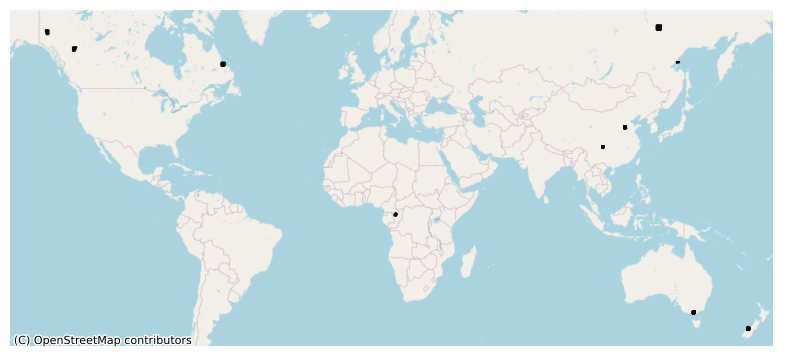

In [ ]:
embeddings.plot()

If the total areas is too big, you can visualize the embeddings areas on detail zoomin in around one:

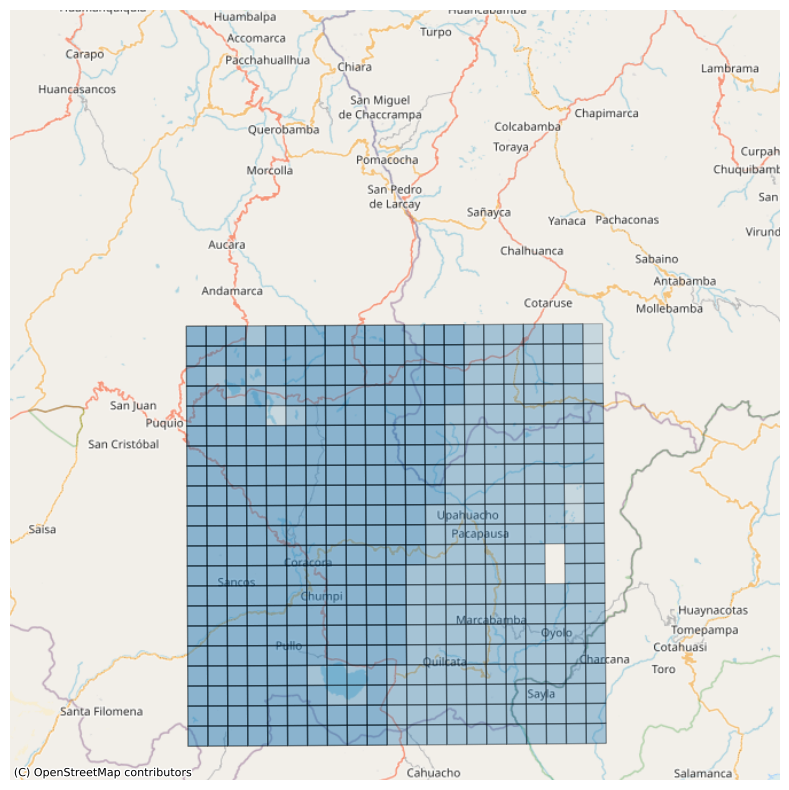

In [ ]:
# Get the coordinates of one geometry
first_geometry = embeddings.gdf.iloc[50].geometry
# Create a 1km buffer around the first geometry
buffer = first_geometry.buffer(100*1000)  # 10km

xmin, ymin, xmax, ymax = buffer.bounds

# Call the plot method with the bounds
embeddings.plot(bounds=[xmin, xmax, ymin, ymax])

Note that we are using a transparency `alpha=0.2`. Darker areas are where there are several embeddings stacked on top of each other, from different times. 

We can plot the times.

<Axes: >

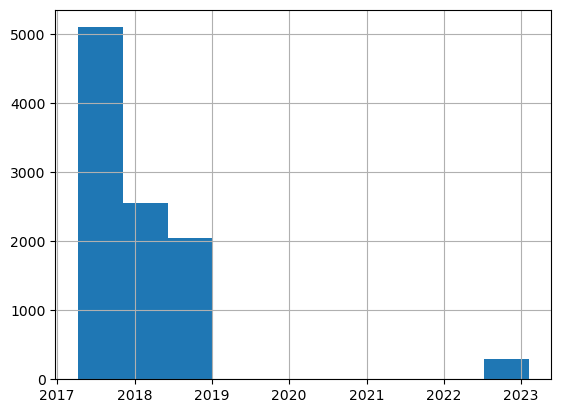

In [ ]:
#plot the histogram of the time range
embeddings.gdf.start_date.hist(bins=10)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()